# Laboratorium 6 - rekomendacje grafowe

## Przygotowanie

 * pobierz i wypakuj dataset `movies_graph.zip`
   * dane źródłowe: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data
   * więcej o przekształceniach i filtrowaniu możesz poczytać w notebooku `movies_graph_data_preparation.ipynb`
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab6`
 * zainstaluj potrzebne biblioteki:
 `pip install pykeen torch tqdm seaborn`

## Część 1. - przygotowanie danych

In [1]:
import os
from collections import defaultdict
from itertools import product
import csv
from random import shuffle
from ast import literal_eval

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.axes import Axes
from prettytable import PrettyTable

from pykeen.losses import loss_resolver
from pykeen.models import ERModel, TransE, TransH, TransR, RESCAL
from pykeen.pipeline import PipelineResult, pipeline
from pykeen.predict import predict_target
from pykeen.triples import TriplesFactory

In [2]:
POSITIVE_RATING_THRESHOLD = 4.0
NEGATIVE_RATING_THRESHOLD = 2.0
PATH = './dataset/movies-graph/'
TRAIN_DATA_RATIO = 0.9

In [3]:
def plot_losses(pipeline_result: PipelineResult) -> None:
    epoch_count = len(pipeline_result.losses)
    epoches = np.arange(1, epoch_count + 1)

    sns.set_theme(style='darkgrid', rc={'figure.figsize': (8, 5)})

    axes = sns.lineplot(y=pipeline_result.losses, x=epoches)

    loss_name = loss_resolver.normalize_inst(pipeline_result.model.loss)

    axes.set_ylabel(f'{loss_name.capitalize()} Loss')
    axes.set_xlabel('Epoch')
    axes.set_xticks(epoches)
    axes.set_title(
        pipeline_result.title
        if pipeline_result.title is not None
        else 'Losses Plot'
    )

    plt.show()

In [4]:
# dataclasses

class Movie:
    def __init__(
        self,
        movie_id: str,
        title: str,
        genres: list[str],
        production_countries: list[str],
        collection_name: str,
        release_year: str
    ):
        self.movie_id = movie_id
        self.title = title
        self.genres = genres
        self.production_countries = production_countries
        self.collection_name = collection_name
        self.release_year = release_year

    def add_cast(
        self,
        actors: list[str],
        directors: list[str],
        screenwriters: list[str],
        music_composers: list[str]
    ) -> None:
        self.actors = actors
        self.directors = directors
        self.screenwriters = screenwriters
        self.music_composers = music_composers

    def basic_info(self) -> dict[str, str | list[str]]:
        return {
            'movie_id': self.movie_id,
            'title': self.title,
            'genres': self.genres,
            'production_countries': self.production_countries
        }

    def __str__(self) -> str:
        return str(vars(self))

    def __repr__(self) -> str:
        return self.__str__()


class Review:
    def __init__(self, user_id: str, movie_id: str, rating: str):
        self.user_id = user_id
        self.movie_id = movie_id
        self.rating = float(rating)

    def __str__(self):
        return str(vars(self))

    def __repr__(self):
        return self.__str__()

In [5]:
# wczytujemy oceny filmow
with open(os.path.join(PATH, 'reviews.csv')) as f:
    reader = csv.reader(f)
    header = next(reader)
    ratings = []
    for entry in list(reader):
        user_id, movie_id, rating = entry
        ratings.append(Review(f'u_{user_id}', f'm_{movie_id}', rating))

# podzial na zbior treningowy i testowy
shuffle(ratings)
train_ratings = ratings[:int(len(ratings)*TRAIN_DATA_RATIO)]
test_ratings = ratings[len(train_ratings):]
train_ratings

[{'user_id': 'u_665', 'movie_id': 'm_3263', 'rating': 4.0},
 {'user_id': 'u_624', 'movie_id': 'm_3255', 'rating': 4.0},
 {'user_id': 'u_664', 'movie_id': 'm_60074', 'rating': 3.0},
 {'user_id': 'u_571', 'movie_id': 'm_7173', 'rating': 2.0},
 {'user_id': 'u_380', 'movie_id': 'm_2616', 'rating': 2.0},
 {'user_id': 'u_418', 'movie_id': 'm_7293', 'rating': 4.0},
 {'user_id': 'u_130', 'movie_id': 'm_6979', 'rating': 4.0},
 {'user_id': 'u_425', 'movie_id': 'm_2987', 'rating': 3.0},
 {'user_id': 'u_621', 'movie_id': 'm_356', 'rating': 4.0},
 {'user_id': 'u_230', 'movie_id': 'm_1089', 'rating': 5.0},
 {'user_id': 'u_587', 'movie_id': 'm_6385', 'rating': 3.0},
 {'user_id': 'u_73', 'movie_id': 'm_6936', 'rating': 2.0},
 {'user_id': 'u_294', 'movie_id': 'm_2321', 'rating': 4.0},
 {'user_id': 'u_661', 'movie_id': 'm_1965', 'rating': 4.0},
 {'user_id': 'u_550', 'movie_id': 'm_527', 'rating': 5.0},
 {'user_id': 'u_265', 'movie_id': 'm_942', 'rating': 4.0},
 {'user_id': 'u_117', 'movie_id': 'm_1835',

In [6]:
# wczytujemy metadane filmow
def parse_movie_metadata(entry: list[str]):
    (
        movie_id,
        title,
        genres,
        production_countries,
        collection_name,
        release_year
    ) = entry

    return Movie(
        f'm_{movie_id}',
        title,
        literal_eval(genres),
        literal_eval(production_countries),
        collection_name,
        release_year
    )


def add_cast_to_movie(movie: Movie, entry: list[str]):
    _movie_id, actors, directors, screenwriters, music_composers = entry
    movie.add_cast(
        literal_eval(actors),
        literal_eval(directors),
        literal_eval(screenwriters),
        literal_eval(music_composers)
    )


with open(os.path.join(PATH, 'metadata.csv')) as f:
    reader = csv.reader(f)
    header = next(reader)
    movies = {f'm_{entry[0]}': parse_movie_metadata(entry) for entry in reader}

with open(os.path.join(PATH, 'credits.csv')) as f:
    reader = csv.reader(f)
    header = next(reader)
    for entry in reader:
        movie_id = f'm_{entry[0]}'
        add_cast_to_movie(movies[movie_id], entry)

movies

{'m_949': {'movie_id': 'm_949', 'title': 'Heat', 'genres': ['Action', 'Crime', 'Drama', 'Thriller'], 'production_countries': ['US'], 'collection_name': '', 'release_year': '1995', 'actors': ['Al Pacino', 'Robert De Niro', 'Val Kilmer', 'Jon Voight', 'Tom Sizemore', 'Diane Venora', 'Amy Brenneman', 'Ashley Judd', 'Mykelti Williamson', 'Natalie Portman', 'Ted Levine', 'Tom Noonan', 'Tone Loc', 'Hank Azaria', 'Wes Studi', 'Dennis Haysbert', 'Danny Trejo', 'Henry Rollins', 'William Fichtner', 'Kevin Gage', 'Susan Traylor', 'Jerry Trimble', 'Ricky Harris', 'Jeremy Piven', 'Xander Berkeley', 'Begonya Plaza', 'Rick Avery', 'Hazelle Goodman', 'Ray Buktenica', 'Max Daniels', 'Vince Deadrick Jr.', 'Steven Ford', 'Farrah Forke', 'Patricia Healy', 'Paul Herman', 'Cindy Katz', 'Brian Libby', 'Dan Martin', 'Mario Roberts', 'Thomas Rosales, Jr.', 'Yvonne Zima', 'Mick Gould', 'Bud Cort', 'Viviane Vives', 'Kim Staunton', 'Martin Ferrero', 'Brad Baldridge', 'Andrew Camuccio', 'Kenny Endoso', 'Kimberly F

## Część 2. - zbudowanie zbioru relacji

In [7]:
# generujemy dane dla modelu w formacie (head, relation, tail)
# na start mozesz uzyc malego podzbioru relacji, np. tylko 'positive_rating'

all_relation_types = [
    'positive_rating',
    'neutral_rating',
    'negative_rating',
    'genre',
    'production_country',
    'in_collection',
    'release_year',
    'actor_in',
    'director_of',
    'screenwriter_of',
    'composer_of'
]
basic_relation_types = [
    'positive_rating',
    'negative_rating'
]

def generate_triples(
    reviews: list[Review],
    movies: dict[str, Movie],
    relation_types: list[str]
) -> list[tuple[str, str, str]]:
    # przetlumacz dane o filmach i recenzjach do formy trojek
    # (head, relation, tail) np. (user_id, 'positive_rating', movie_id)
    # zwroc liste trzyelementowych krotek
    return [
        (review.user_id, relation, review.movie_id)
        for relation in relation_types
        for review in reviews
    ]

triples_factories = generate_triples(ratings, movies, basic_relation_types)
tf = TriplesFactory.from_labeled_triples(np.array(triples_factories))

## Część 3. - trening modelu

In [8]:
def train_model(
    tf: TriplesFactory,
    model: ERModel | None = None,
    epochs=10,
    title: str | None = None
):
    if model is None:
        model = TransE  # to najszybszy i najprostszy, ale i najslabszy model
    if title:
        metadata = { 'title': title }

    # tworzymy obiekt pomocniczy do reprezentacji zbioru danych
    training, testing, validation = tf.split([.8, .1, .1])

    # fix dla niektorych makow
    # mps_device = torch.device('mps')

    # zasadnicza czesc treningu
    pipeline_result: PipelineResult = pipeline(
        # device=mps_device,
        training=training,
        testing=testing,
        validation=validation,
        model=model,
        epochs=epochs,
        metadata=metadata
    )

    return pipeline_result

using automatically assigned random_state=1234135539
No random seed is specified. Setting to 696702987.
No cuda devices were available. The model runs on CPU


Training epochs on cpu:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/16.1k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 19.69s seconds


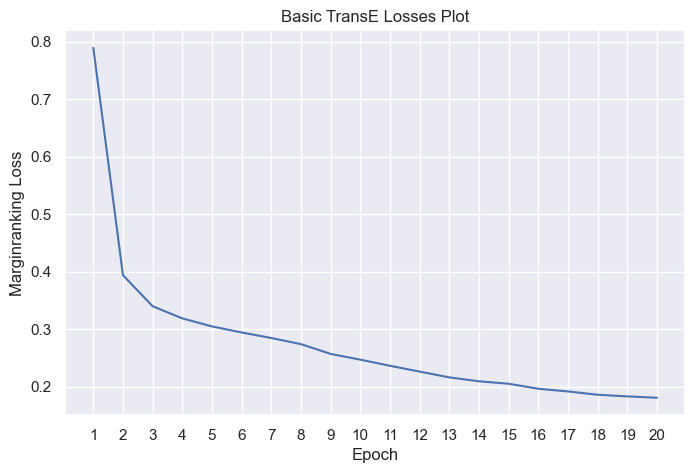

In [9]:
pipeline_result = train_model(tf, epochs=20, title='Basic TransE Losses Plot')

# wykres loss function
plot_losses(pipeline_result)

## Część 4. - rekomendacje

In [10]:
# funkcje pomocnicze

def print_movies(
    movie_ids: list[str],
    movies: dict[str, Movie],
    print_missing=True
) -> None:
    for m_id in movie_ids:
        if m_id in movies:
            print(movies[m_id].basic_info())
        elif print_missing:
            print(f'movie_id: {m_id}')


def print_recommendation(
    recommendation: list[str],
    movies: dict[str, Movie],
    print_missing=True
) -> None:
    for m_id in recommendation:
        if m_id in movies:
            print(f'Movie ID: {m_id}, Title: "{movies[m_id].title}"')
        elif print_missing:
            print(f'Movie ID: {m_id}')


def describe_user(
    user_id: str,
    reviews: list[Review],
    movies: dict[str, Movie]
) -> None:
    positive_ratings = [
        x.movie_id for x in reviews
        if x.user_id == user_id and x.rating >= POSITIVE_RATING_THRESHOLD
    ]
    negative_ratings = [
        x.movie_id for x in reviews
        if x.user_id == user_id and x.rating <= NEGATIVE_RATING_THRESHOLD
    ]
    neutral_ratings = [
        x.movie_id for x in reviews
        if x.user_id == user_id
            and x.rating > NEGATIVE_RATING_THRESHOLD
            and x.rating < POSITIVE_RATING_THRESHOLD
    ]

    print(f'user_id: {user_id}')
    print('Positive ratings:')
    print_movies(positive_ratings, movies, print_missing=False)
    print('Neutral ratings:')
    print_movies(neutral_ratings, movies, print_missing=False)
    print('Negative ratings:')
    print_movies(negative_ratings, movies, print_missing=False)

In [11]:
def recommend(
    user_id: str,
    model: ERModel,
    triples_factory: TriplesFactory,
    k: int
) -> list[str]:
    relation = 'positive_rating'
    prediction = predict_target(
        model, head=user_id, relation=relation, triples_factory=triples_factory
    )
    # wygeneruj rekomendacje na podstawie predykcji
    movie_labels = prediction.df['tail_label'].str.startswith('m')
    return prediction.df['tail_label'][movie_labels].values[:k].tolist()

In [12]:
# user_id = 'u_547' # uzytkownik z bardzo duza historia
user_id = 'u_244'
describe_user(user_id, ratings, movies)
recommendation = recommend(user_id, pipeline_result.model, tf, 20)
print('Recommendation:')
recommendation
print_recommendation(recommendation, movies)

user_id: u_244
Positive ratings:
{'movie_id': 'm_2005', 'title': 'Sister Act', 'genres': ['Music', 'Comedy'], 'production_countries': ['US']}
{'movie_id': 'm_54272', 'title': '座頭市関所破り', 'genres': ['Adventure', 'Action', 'Drama'], 'production_countries': ['JP']}
{'movie_id': 'm_4886', 'title': 'And Then There Were None', 'genres': ['Crime', 'Drama', 'Mystery'], 'production_countries': ['US']}
{'movie_id': 'm_41569', 'title': 'The Nomi Song', 'genres': ['Documentary', 'Foreign'], 'production_countries': ['DE']}
{'movie_id': 'm_54001', 'title': 'مسافر', 'genres': ['Drama'], 'production_countries': ['IR']}
{'movie_id': 'm_1376', 'title': 'Sweet Sixteen', 'genres': ['Crime', 'Drama'], 'production_countries': ['GB']}
{'movie_id': 'm_318', 'title': 'The Million Dollar Hotel', 'genres': ['Drama', 'Thriller'], 'production_countries': ['US', 'DE']}
{'movie_id': 'm_2028', 'title': 'Say Anything...', 'genres': ['Comedy', 'Drama', 'Romance'], 'production_countries': ['US']}
{'movie_id': 'm_4993', '

## Część 5. - metryki

In [13]:
def create_user_recommendations(
    user_ids: set[str],
    model: ERModel,
    tf: TriplesFactory,
    k: int
) -> dict[str, list[str]]:
    user_recommendations: dict[str, list[str]] = {}
    for user_id in user_ids:
        user_recommendations[user_id] = recommend(user_id, model, tf, k)

    return user_recommendations


def get_user_positive_reviews(
    test_ratings: list[Review]
) -> dict[str, list[Review]]:
    user_positive_reviews: dict[str, list[Review]] = defaultdict(list)
    for review in test_ratings:
        if review.rating >= POSITIVE_RATING_THRESHOLD:
            user_positive_reviews[review.user_id].append(review)

    return user_positive_reviews

In [14]:
# HitRatio@k - iterujemy po testowym zbiorze ocen, odsiewamy tylko oceny pozytywne,
# generujemy rekomendacje dlugosci k dla uzytkownika i sprawdzamy, czy oceniony film znalazl sie w rekomendacji
# zwracamy stosunek liczby trafien do liczby wszystkich prob

# wersja nieco bardziej zaawansowana - zamiast rekomendacji wyciagamy z modelu predykcje konkretnej relacji
# i liczymy skutecznosc w przewidywaniu, czy ocena byla pozytywna, negatywna czy neutralna

def hit_ratio(
    test_ratings: list[Review],
    model: ERModel,
    tf: TriplesFactory,
    k: int
) -> float:
    user_ids = {review.user_id for review in test_ratings}
    user_recommendations = create_user_recommendations(user_ids, model, tf, k)
    user_positive_reviews = get_user_positive_reviews(test_ratings)

    hit_count = sum([
        1
        for user_id in user_ids
        for review in user_positive_reviews[user_id]
        if review.movie_id in user_recommendations[user_id]
    ])

    return hit_count / (len(user_recommendations) * k)


hit_ratio(test_ratings, pipeline_result.model, tf, 50)

0.029877300613496933

In [15]:
# AvgPosition@k - iterujemy po testowym zbiorze ocen, odsiewamy tylko oceny pozytywne,
# generujemy rekomendacje dlugosci k dla uzytkownika i sprawdzamy, czy oceniony film znalazl sie w rekomendacji
# jesli tak, zapisujemy pozycje, na ktorej zarekomendowano film
# zwracamy srednia pozycje, na ktorych wystepowaly filmy

def avg_position(
    test_ratings: list[Review],
    model: ERModel,
    tf: TriplesFactory,
    k: int
) -> float:
    user_ids = {review.user_id for review in test_ratings}
    user_recommendations = create_user_recommendations(user_ids, model, tf, k)
    user_positive_movies = get_user_positive_reviews(test_ratings)

    total_recommended_movie_count: int = 0
    cumulative_position_indicies: int = 0

    for user_id, reviews in user_positive_movies.items():
        for review in reviews:
            if review.movie_id in user_recommendations[user_id]:
                total_recommended_movie_count += 1
                cumulative_position_indicies += user_recommendations[user_id] \
                    .index(review.movie_id)

    return cumulative_position_indicies / total_recommended_movie_count


avg_position(test_ratings, pipeline_result.model, tf, 50)

21.976386036960985

## Część 6. - porównanie modeli

Wytrenowaliśmy podstawowy model, umiemy wygenerować rekomendacje i ocenić jakość modelu. Teraz przeanalizujemy, jakie zmiany mogą pozytywnie wpłynąć na jakość rekomendacji.

Porównaj bazowy model (np. TransH wytrenowany tylko na relacjach `positive_rating` i `negative_rating`) z dwoma innymi podejściami. Wybierz dwie spośród poniszych modyfikacji lub zaproponuj własną:
1. Zmiana modelu - zamiast TransH możesz użyć np. TransR albo RESCAL
2. Dodanie większej liczby typów relacji - możesz dodać oceny neutralne, metadane filmu, informacje o obsadzie. Nawet jeśli jakaś relacja nie jest wykorzystywana w procesie rekomendacji, może poprawić jakość wytrenowanego modelu. Zwróć uwagę, by jako rekoemndację zwracać wyłącznie identyfikatory filmów, nie innych wierzchołków.
3. Zmiana sposobu rekomendacji - obecny tryb opiera się na przewidywaniu relacji `positive_rating`. Możesz poprawić ten proces przez np. odsiewanie tych kandydatów, którzy występują także w predykcji relacji `negative_rating` czy filtrowanie kandydatów po metadanych (np. gatunku).

Porównanie trzech modeli oprzyj na dwóch zdefiniowanych w Części 4. metrykach dla wybranej wartości `k`.

In [16]:
def generate_advanced_triples(
    reviews: list[Review],
    movies: dict[str, Movie],
    relation_types: list[str]
) -> list[tuple[str, str, str]]:
    triples: tuple[str, str, str] = []

    for review in reviews:
        if review.rating >= POSITIVE_RATING_THRESHOLD:
            triples.append((review.user_id, relation_types[0], review.movie_id))
        elif review.rating > NEGATIVE_RATING_THRESHOLD:
            triples.append((review.user_id, relation_types[1], review.movie_id))
        else:
            triples.append((review.user_id, relation_types[2], review.movie_id))

    for movie in movies.values():
        movie_attributes: list[str | list[str]] = [
            movie.genres,
            movie.production_countries,
            movie.collection_name,
            movie.release_year,
            movie.actors,
            movie.directors,
            movie.screenwriters,
            movie.music_composers
        ]
        for i, attribute in enumerate(movie_attributes):
            if type(attribute) == list:
                for attr in attribute:
                    triples.append((attr, relation_types[i + 3], movie_id))
            else:
                triples.append((attribute, relation_types[i + 3], movie_id))

    return triples

In [17]:
def train_models(
    models: list[tuple[str, ERModel]],
    triples_factories: list[
        tuple[str, list[tuple[str, str, str]], TriplesFactory]
    ],
    epochs=10
) -> list[tuple[str, TriplesFactory, PipelineResult]]:
    results: list[tuple[str, TriplesFactory, PipelineResult]] = []

    for (model_name, model), (tf_name, tf) in product(
        models, triples_factories
    ):
        pipeline_result = train_model(
            tf,
            model,
            epochs,
            title=f'{tf_name.capitalize()} {model_name} Losses Plot'
        )

        plot_losses(pipeline_result)

        results.append(
            (f'{tf_name.capitalize()} {model_name}', tf, pipeline_result)
        )

    return results

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [125832, 16057, 16058]
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/16.1k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 19.85s seconds


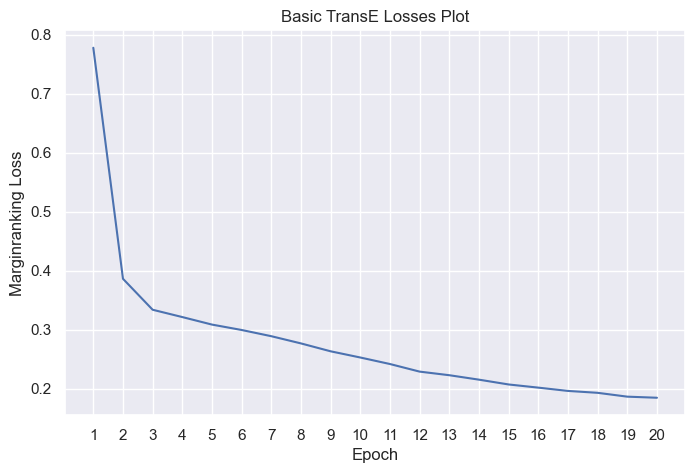

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [58599, 9867, 9867]
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/9.87k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 67.30s seconds


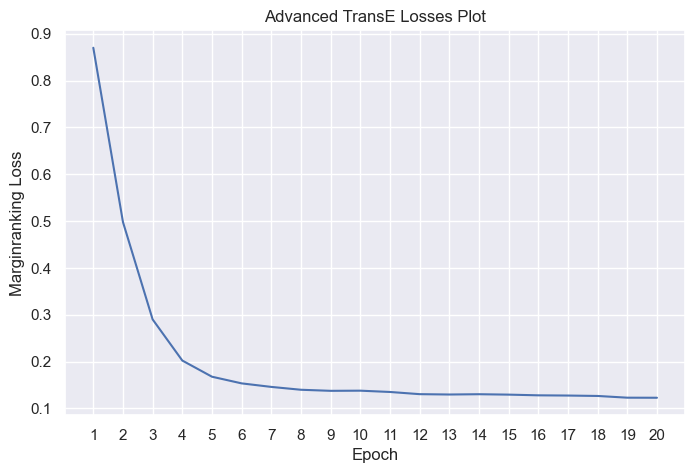

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [125832, 16057, 16058]
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/16.1k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 9.09s seconds


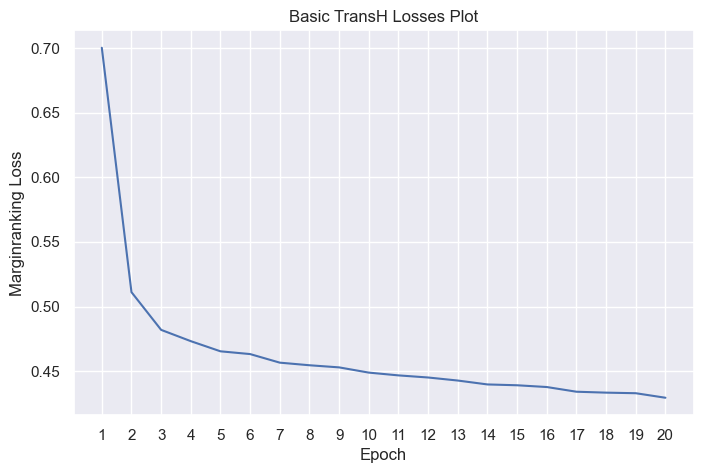

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [58599, 9867, 9867]
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/9.87k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 21.45s seconds


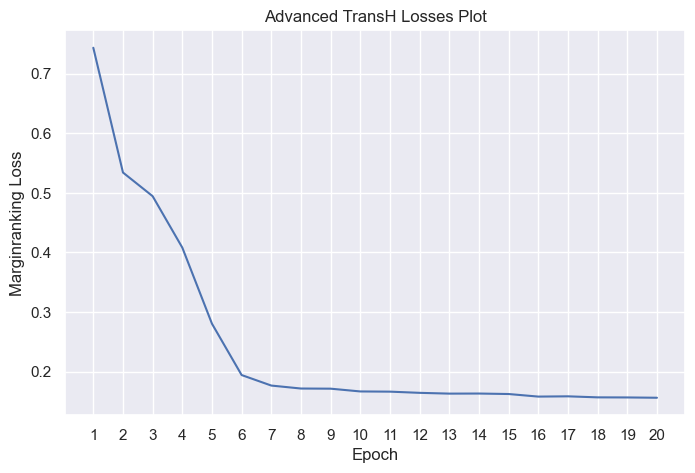

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [125832, 16057, 16058]
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/16.1k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 38.27s seconds


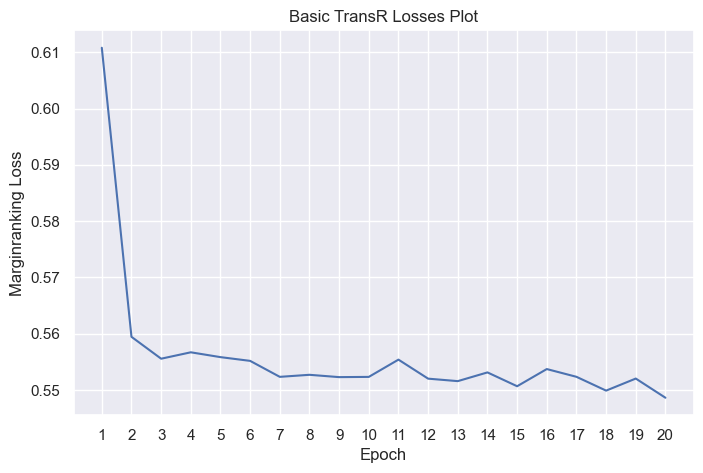

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [58599, 9867, 9867]
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/9.87k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 156.59s seconds


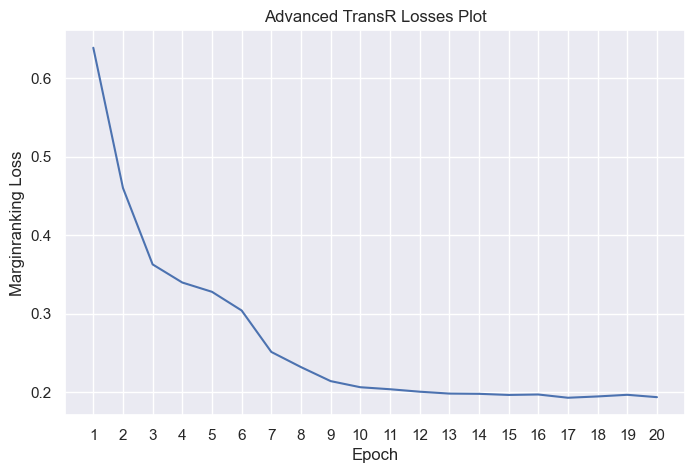

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [125832, 16057, 16058]
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/502 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/16.1k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 7.26s seconds


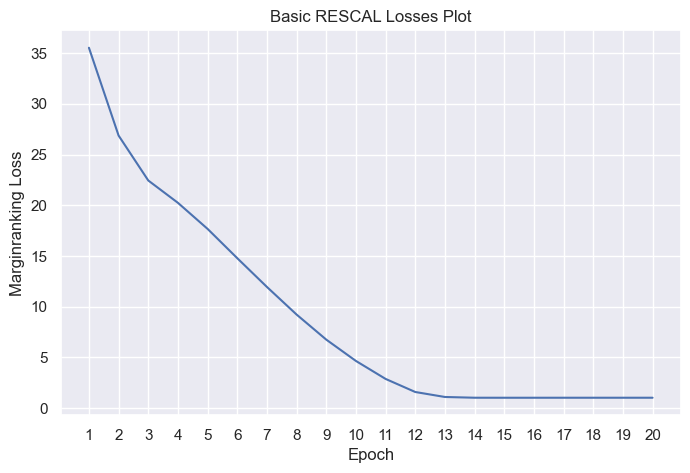

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [58599, 9867, 9867]
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/309 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/9.87k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 10.35s seconds


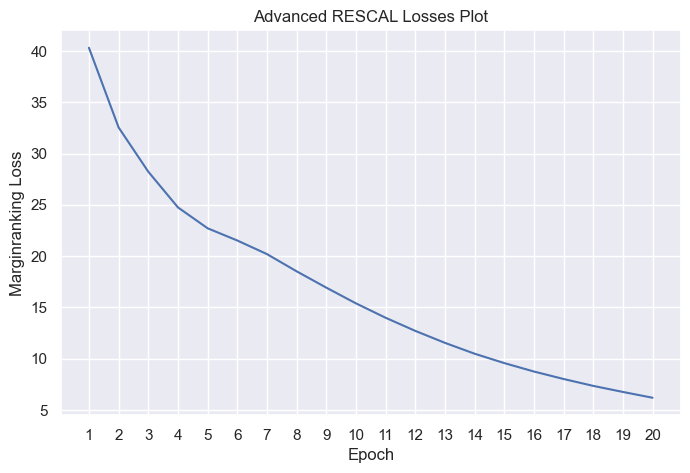

In [18]:
models: list[tuple[str, ERModel]] = [
    ('TransE', TransE),
    ('TransH', TransH),
    ('TransR', TransR),
    ('RESCAL', RESCAL),
]

basic_triples = generate_triples(ratings, movies, basic_relation_types)
advanced_triples = generate_advanced_triples(
    ratings, movies, all_relation_types
)

triple_factories: list[tuple[
    str, list[tuple[str, str, str]], TriplesFactory
]] = [
    (
        'basic',
        TriplesFactory.from_labeled_triples(np.array(basic_triples)),
    ),
    (
        'advanced',
        TriplesFactory.from_labeled_triples(np.array(advanced_triples)),
    ),
]

trained_results: list[tuple[str, TriplesFactory, PipelineResult]] \
    = train_models(models, triple_factories, epochs=20)

In [19]:
def print_results(
    trained_results: list[tuple[str, TriplesFactory, PipelineResult]],
    ks: list[int]
) -> None:
    last_k = ks[-1]
    result_product = product(enumerate(trained_results, start=1), ks)

    table = PrettyTable(field_names=[
        'Model', 'k', 'Hit Ratio@k', 'Average Position@k'
    ])

    for (mi, (model_name, tf, pipeline_result)), k in result_product:
        hit_ratio_at_k = hit_ratio(test_ratings, pipeline_result.model, tf, k)
        avg_position_at_k = avg_position(
            test_ratings, pipeline_result.model, tf, k
        )

        table.add_row(
            [model_name, k, hit_ratio_at_k, avg_position_at_k],
            divider=not mi % 2 and k == last_k
        )

    print(table)

In [20]:
print_results(trained_results, ks=[5, 10, 25, 50])

+-----------------+----+-----------------------+--------------------+
|      Model      | k  |      Hit Ratio@k      | Average Position@k |
+-----------------+----+-----------------------+--------------------+
|   Basic TransE  | 5  |  0.04233128834355828  | 1.891304347826087  |
|   Basic TransE  | 10 |  0.03773006134969325  | 4.040650406504065  |
|   Basic TransE  | 25 |  0.03245398773006135  | 10.911153119092628 |
|   Basic TransE  | 50 |  0.02763803680981595  | 21.433962264150942 |
| Advanced TransE | 5  |  0.02607361963190184  | 2.1411764705882352 |
| Advanced TransE | 10 |  0.02561349693251534  | 4.508982035928144  |
| Advanced TransE | 25 |  0.021042944785276074 | 10.900874635568513 |
| Advanced TransE | 50 |  0.01834355828220859  | 21.994983277591974 |
+-----------------+----+-----------------------+--------------------+
|   Basic TransH  | 5  |  0.023312883435582823 | 1.9210526315789473 |
|   Basic TransH  | 10 |  0.020552147239263803 | 4.141791044776119  |
|   Basic TransH  | 